In [1]:
pwd

In [2]:
import cv2                 
import numpy as np         
import os                  
from random import shuffle
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob as gb
from tensorflow.keras.utils import to_categorical

In [3]:
#read DataSet
TrainImage='C:\\Users\\Dell\\Downloads\\train\\train'
TestImage='C:\\Users\\Dell\\Downloads\\train\\test'


print(TrainImage)
print(TestImage)

C:\Users\Dell\Downloads\train\train
C:\Users\Dell\Downloads\train\test


In [4]:
#to get all image names in train file
Pneumoniaimages = os.listdir(TrainImage + "/PNEUMONIA")
Normalimages = os.listdir(TrainImage + "/NORMAL")
COVID19images = os.listdir(TrainImage + "/COVID19")






# # **Explore the Data**

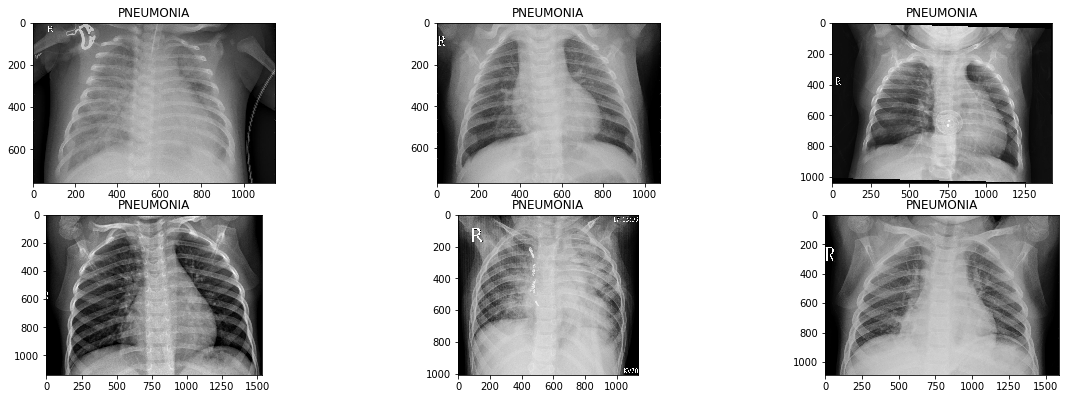

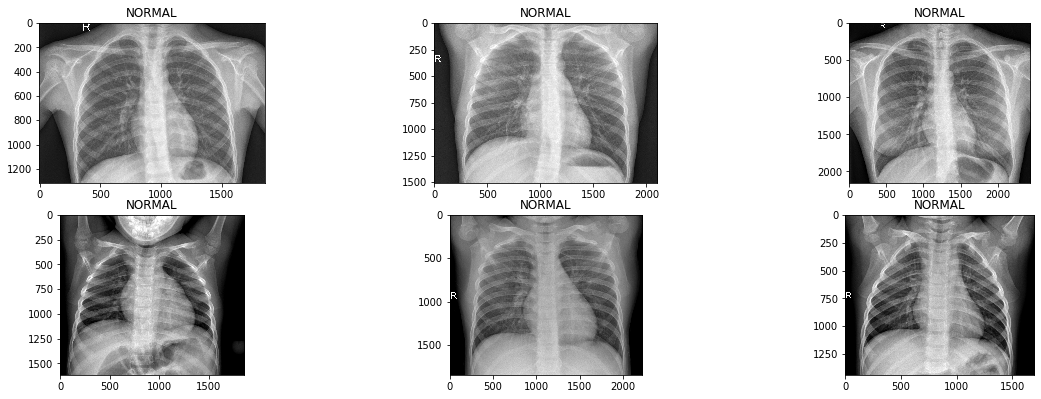

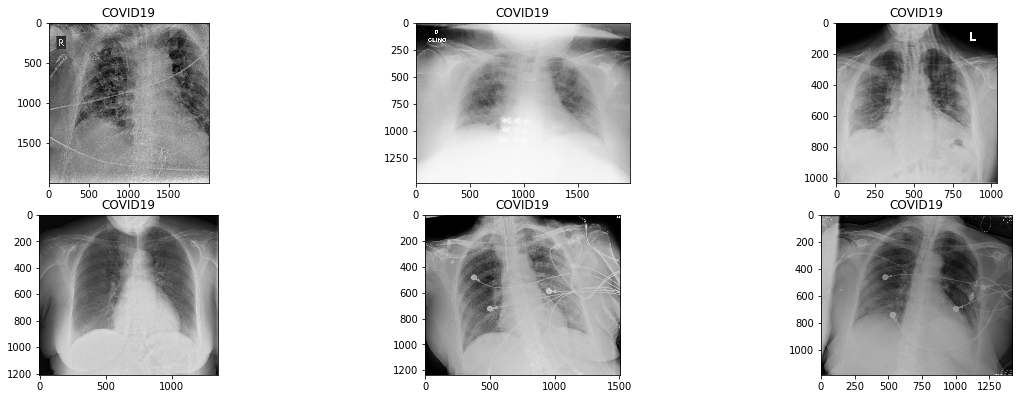

In [5]:
#plot to show the size of some image
#plot PNEUMONIA
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrainImage + "/PNEUMONIA",Pneumoniaimages[i])),cmap='gray')
    plt.title("PNEUMONIA")
    
plt.show()
#plot NORMAL
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrainImage + "/NORMAL",Normalimages[i])),cmap='gray')
    plt.title("NORMAL")

plt.show()
#plot 
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrainImage + "/COVID19",COVID19images[i])),cmap='gray')
    plt.title("COVID19")

# ImageDataGenerator (DataAugmentation )

We also use the generator to transform the values in each batch so that their mean is $0$ and their standard deviation is 1.
This will facilitate model training by standardizing the input distribution

The generator also converts our single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels.
We will want this because the pre-trained model that we'll use requires three-channel inputs.

In [6]:
train_datagen = ImageDataGenerator(
      samplewise_center=True,
      samplewise_std_normalization= True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest'
                                  )

# NOTE: YOU MUST USE A BATCH SIZE OF 10 (batch_size=10) FOR THE 
# TRAIN GENERATOR.
train_generator =train_datagen.flow_from_directory(
     TrainImage,
     batch_size= 256,
     shuffle=shuffle,
     target_size=(300, 300)

)

test_generator =train_datagen.flow_from_directory(
     TestImage,
     batch_size= 50,
     shuffle=shuffle,
     target_size=(300, 300)

)


Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [7]:
trainShape=train_generator.__getitem__(0)[0].shape
testShape=test_generator.__getitem__(0)[0].shape

In [8]:
#Shape of Data
print("Train Shape \n",trainShape)
print("Test Shape \n",testShape)

Train Shape 
 (256, 300, 300, 3)
Test Shape 
 (50, 300, 300, 3)


In [9]:


Labels={'NORMAL':0,'PNEUMONIA':1,'COVID19':2}

# convert label to code
def getCode(label):
    return Labels[label]


# convert code to label 
def getLabel(n):
    for x,c in Labels.items():
        if n==c:
            return x
        
        
        
#Test        
print(getCode('COVID19'))
print(getLabel(1))

2
PNEUMONIA


# Explore Data After DataAugmentation and standardizing 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


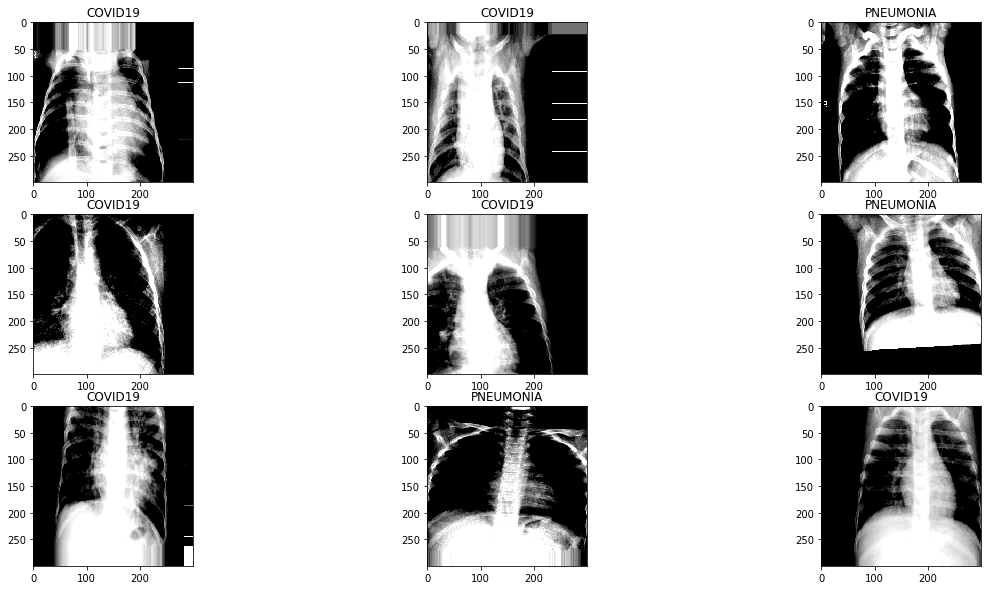

In [10]:
plt.figure(figsize=(20,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_generator.__getitem__(0)[0][i])
    plt.title(getLabel(np.argmax(train_generator.__getitem__(0)[1][i])) )

# Build Model

In [11]:
from tensorflow.keras.applications import DenseNet169

In [12]:
sizeImage=300


In [13]:
from tensorflow.keras.applications.densenet import DenseNet169
pre_trained_model = DenseNet169(input_shape = (sizeImage, sizeImage, 3), 
                                include_top = False, 
                                weights = 'imagenet')

In [14]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [15]:
pre_trained_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [16]:
from tensorflow.keras import Model


x = tf.keras.layers.Flatten()(pre_trained_model.output)

#Full Connected Layers
x = tf.keras.layers.Dense(512, activation='relu')(x)
#Add dropout to avoid Overfit
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
#Add dropout to avoid Overfit
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)


x=tf.keras.layers.Dense(3 , activation='sigmoid')(x)
       

model = Model( pre_trained_model.input, x) 

print(model.summary())
model.compile(optimizer='adam', loss="binary_crossentropy",metrics=['accuracy'])


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

filepath="transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [18]:
epochs = 30
history = model.fit_generator(train_generator,steps_per_epoch=20,callbacks=[lr_reduce,checkpoint] ,
         epochs=epochs)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 20 steps
Epoch 1/30
20/20 [==============================] - 3777s 189s/step - loss: 2.4038 - accuracy: 0.7256
Epoch 2/30
20/20 [==============================] - 3522s 176s/step - loss: 0.4453 - accuracy: 0.8428
Epoch 3/30
20/20 [==============================] - 3524s 176s/step - loss: 0.2297 - accuracy: 0.9135
Epoch 4/30
20/20 [==============================] - 3689s 184s/step - loss: 0.1738 - accuracy: 0.9386
Epoch 5/30
20/20 [==============================] - 3517s 176s/step - loss: 0.1360 - accuracy: 0.9519
Epoch 6/30
20/20 [==============================] - 3514s 176s/step - loss: 0.1240 - accuracy: 0.9568
Epoch 7/30
20/20 [==============================] - 3544s 177s/step - loss: 0.1104 - accuracy: 0.9607
Epoch 8/30
20/20 [==============================] - 5507s 275s/step - loss: 0.1009 - accuracy: 0.9652
Epoch 9/30
20/20 [==============================] - 4185s 209s/s

20/20 [==============================] - 3550s 178s/step - loss: 0.0744 - accuracy: 0.9729
Epoch 21/30
20/20 [==============================] - 3535s 177s/step - loss: 0.0732 - accuracy: 0.9742
Epoch 22/30
20/20 [==============================] - 3521s 176s/step - loss: 0.0654 - accuracy: 0.9789
Epoch 23/30
20/20 [==============================] - 3529s 176s/step - loss: 0.0677 - accuracy: 0.9747
Epoch 24/30
20/20 [==============================] - 3518s 176s/step - loss: 0.0652 - accuracy: 0.9734
Epoch 25/30
20/20 [==============================] - 3512s 176s/step - loss: 0.0605 - accuracy: 0.9785
Epoch 26/30
20/20 [==============================] - 3509s 175s/step - loss: 0.0664 - accuracy: 0.9769
Epoch 27/30
20/20 [==============================] - 3502s 175s/step - loss: 0.0621 - accuracy: 0.9766
Epoch 28/30
20/20 [==============================] - 3503s 175s/step - loss: 0.0619 - accuracy: 0.9796
Epoch 29/30
20/20 [==============================] - 3500s 175s/step - loss: 0.0647 -

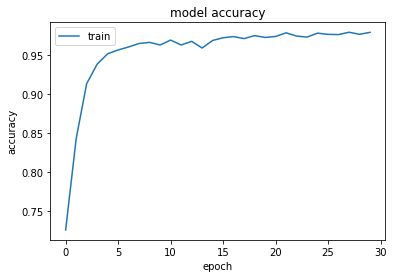

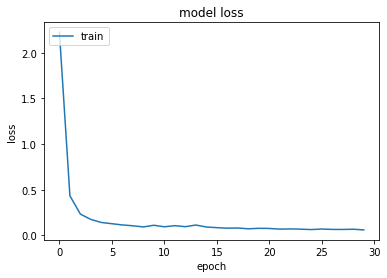

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [20]:
#Evaluate Model
model.evaluate(test_generator)

  ...
    to  
  ['...']
26/26 [==============================] - 284s 11s/step - loss: 0.5977 - accuracy: 0.8333


[0.5976572162829913, 0.8333334]

In [21]:
model.save('modelweight.h5')

In [22]:
#prediction
pred=model.predict(test_generator)

In [23]:
print(len(pred))

1288


In [24]:
y_test=[]
for i in range(26):
    y_test.extend(test_generator.__getitem__(i)[1])

In [25]:
print(len(y_test))
y_test=np.array(y_test)

1288


In [26]:
y_test=np.argmax(y_test,axis=1)
pred= np.argmax(pred,axis=1)

In [27]:
print("pred \n",len(pred))
print("y_test \n",len(y_test))

pred 
 1288
y_test 
 1288


In [28]:
print("y_test \n",y_test)
print("pred \n",pred)

y_test 
 [2 2 2 ... 0 2 2]
pred 
 [2 2 2 ... 2 2 2]


In [29]:
#confusion_matrix to check in accuracy 
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(pred,y_test)
print(cm)

[[  6   0   0]
 [  0  85   9]
 [110 232 846]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


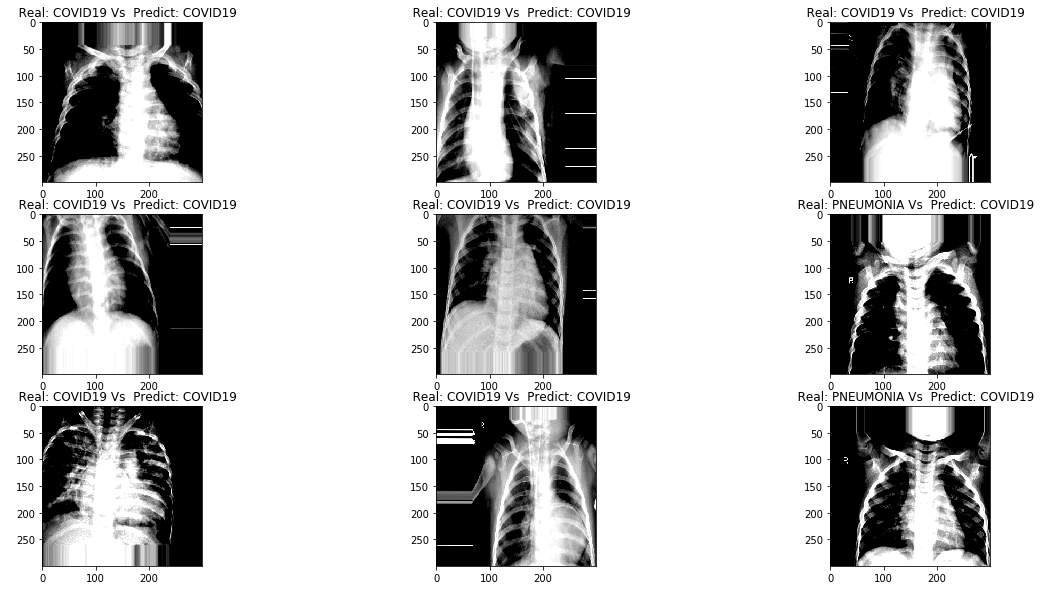

In [30]:
plt.figure(figsize=(20,10))
for i in range(0,9):
    
    plt.subplot(3, 3, i + 1)
    
    plt.imshow(test_generator.__getitem__(0)[0][i],cmap='gray')
    plt.title(f"   Real: {getLabel(y_test[i])   } Vs  Predict: {getLabel(pred[i])}")

## End of the notebook